In [1]:
import pandas               as pd
import numpy                as np
import plotly.express       as px
import plotly.graph_objects as go
import ipywidgets           as widgets
from ipywidgets      import fixed, interact, interact_manual
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from geopy.geocoders import Nominatim

# set float type display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# set plots size
plt.rcParams['figure.figsize'] = [ 20, 10 ]

## 0. Carga

In [2]:
df_raw = pd.read_csv('../data/processed/kc_house_processed.csv',parse_dates=['date'])
print(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21436 entries, 0 to 21435
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21436 non-null  int64         
 1   date           21436 non-null  datetime64[ns]
 2   price          21436 non-null  float64       
 3   bedrooms       21436 non-null  int64         
 4   bathrooms      21436 non-null  int64         
 5   sqft_living    21436 non-null  int64         
 6   sqft_lot       21436 non-null  int64         
 7   floors         21436 non-null  int64         
 8   waterfront     21436 non-null  int64         
 9   view           21436 non-null  int64         
 10  condition      21436 non-null  int64         
 11  grade          21436 non-null  int64         
 12  sqft_above     21436 non-null  int64         
 13  sqft_basement  21436 non-null  int64         
 14  yr_built       21436 non-null  int64         
 15  yr_renovated   2143

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,year
0,7129300520,2014-10-13,221900.00,3,1,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,2014
1,6414100192,2014-12-09,538000.00,3,2,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,2014
2,5631500400,2015-02-25,180000.00,2,1,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2015
3,2487200875,2014-12-09,604000.00,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,2014
4,1954400510,2015-02-18,510000.00,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,2015


## 1. Engenharia de atributos

#### 1.1. Criando variáveis

In [3]:
#new attributes
data = df_raw.copy()
data['month'] = data['date'].dt.month
data['month_name'] = data['date'].dt.month_name()
data['season'] = data['month'].apply(lambda x: 'winter' if x in(12,1,2) else
                                               'spring' if x in(3,4,5) else
                                               'summer' if x in(6,7,8) else 'fall' )
data['condition_type'] = data['condition'].apply(lambda x: 'good' if x==5 else 'regular' if x in(3,4) else 'bad')
# definindo mediana do custo por região
regional_median = data[['zipcode','price']].groupby('zipcode').median().reset_index().copy()
regional_median.columns = ['zipcode','regional_median']
# definindo mediana do custo por região/estação
season_region_median = data[['price','zipcode','season']].groupby(['zipcode','season']).median('price')
season_region_median = season_region_median.rename(columns={'price': 'season_median'}).reset_index(drop=False)

#### 1.1. Definição dos imóveis para compra

In [4]:
data = pd.merge(data,regional_median,how='left',on='zipcode').copy()
data['buy'] = data.apply(lambda x: 'Yes' if (x['price'] < x['regional_median']) & (x['condition_type']=='good') else 'No',axis=1 )

#### 1.3. Dados de geolocalização dos imóveis elegíveis

In [5]:
# dados de geolocalização
geolocation = data.loc[data['buy'] == 'Yes'][['id', 'lat', 'long']].copy().reset_index( drop=True )
geolocator = Nominatim( user_agent='geoapiExercises' )
geolocation['street'] = 'NA'
geolocation['house_num'] = 'NA'
geolocation['city'] = 'NA'
geolocation['neighbourhood'] = 'NA'
geolocation['county'] = 'NA'
geolocation['state'] = 'NA'
for i in range( len( geolocation ) ):
    query = str( geolocation.loc[i, 'lat'] ) + ',' + str( geolocation.loc[i, 'long'] )
    response = Nominatim( user_agent=f'geoapiExercises{i}' ).reverse( query )
    response = pd.json_normalize( response.raw['address'] )
    geolocation.iloc[i, 3] = response.apply( lambda x: x['road']          if 'road'          in response.columns else 'NA', axis = 1 )    
    geolocation.iloc[i, 4] = response.apply( lambda x: x['house_number']  if 'house_number'  in response.columns else 'NA', axis = 1 )
    geolocation.iloc[i, 5] = response.apply( lambda x: x['city']          if 'city'          in response.columns else 'NA', axis = 1 )
    geolocation.iloc[i, 6] = response.apply( lambda x: x['neighbourhood'] if 'neighbourhood' in response.columns else 'NA', axis = 1 )
    geolocation.iloc[i, 7] = response.apply( lambda x: x['county']        if 'county'        in response.columns else 'NA', axis = 1 )
    geolocation.iloc[i, 8] = response.apply( lambda x: x['state']         if 'state'         in response.columns else 'NA', axis = 1 )
geolocation['address'] = geolocation['street'] + ', ' + geolocation['house_num']
geolocation.to_csv('../data/processed/geoloc.csv', index=False)

#### 1.4. Definição do preço de revenda

In [16]:
data = pd.merge(data,season_region_median,how='left',on=['zipcode','season'])
data['sell_price'] = data.apply(lambda x: x['price'] * 1.3 if x['price'] <  x['season_median'] and x['buy']=='Yes' else
                                                    x['price'] * 1.1 if x['price'] >= x['season_median'] and x['buy']=='Yes'
                                                    else 0, axis=1)
data['diff_price'] = data.apply(lambda x: np.sqrt((x['sell_price']-x['season_median'])**2) if x['sell_price']!=0 else 0,axis=1)
data['profit'] = data.apply(lambda x: x['sell_price'] - x['price'] if x['buy'] == "Yes" else 0, axis=1)
data = data.drop(['year', 'month', 'month_name'],axis = 1)

## 2. Métricas

In [10]:
# tamanho da base
data.shape[0]

21436

In [11]:
# custo total da base
data['price'].sum()*1e-9

11.610808601

In [12]:
# total imóveis sugeridos
data.loc[data['buy']=="Yes",'id'].count()

698

In [13]:
# investimento total previsto
data.loc[data['buy']=="Yes",'price'].sum()*1e-3

274533.916

In [14]:
# faturamento total previsto
data.loc[data['buy']=="Yes",'sell_price'].sum()

351794370.4

In [25]:
f"${data.loc[data['buy']=="Yes",'sell_price'].sum()*1e-6:1.1f}K"

'$351.8K'

In [15]:
# lucro total previsto
data.loc[data['buy']=="Yes",'profit'].sum()

77260454.4

In [23]:
# lucro total previsto %
aux = data.loc[data['buy']=="Yes",['price','profit']].sum().reset_index()
aux.columns=['feature','value']
val = (aux['value'].pct_change()+1).dropna().values[0]
#val*100
f"{val*100:.1f}%"

'28.1%'

In [ ]:
# imóveis por estado de conservação
data[['condition_type','id']].groupby('condition_type').count().reset_index()

In [ ]:
# rentabilidade por estação do ano
data[['season','profit']].groupby('season').sum().reset_index()

In [ ]:
# preco do m2 por regiao
aux = data[['zipcode','sqft_lot','price']].copy()
aux['price_m2'] = aux['price']/aux['sqft_lot']
aux2 = aux[['zipcode','price_m2']].groupby('zipcode').mean().reset_index()
aux2

## 3. Visualizações

#### 3.1. Pareto

In [162]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,season,condition_type,regional_median,buy,season_median,sell_price,diff_price,profit
0,7129300520,2014-10-13,221900.00,3,1,1180,5650,1,0,0,...,47.51,-122.26,fall,regular,279500.00,No,294000.00,0.00,0.00,0.00
1,6414100192,2014-12-09,538000.00,3,2,2570,7242,2,0,0,...,47.72,-122.32,winter,regular,425000.00,No,425000.00,0.00,0.00,0.00
2,5631500400,2015-02-25,180000.00,2,1,770,10000,1,0,0,...,47.74,-122.23,winter,regular,442500.00,No,446500.00,0.00,0.00,0.00
3,2487200875,2014-12-09,604000.00,4,3,1960,5000,1,0,0,...,47.52,-122.39,winter,good,489950.00,No,487450.00,0.00,0.00,0.00
4,1954400510,2015-02-18,510000.00,3,2,1680,8080,1,0,0,...,47.62,-122.05,winter,regular,645000.00,No,648713.50,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21431,263000018,2014-05-21,360000.00,3,2,1530,1131,3,0,0,...,47.70,-122.35,spring,regular,550000.00,No,565000.00,0.00,0.00,0.00
21432,6600060120,2015-02-23,400000.00,4,2,2310,5813,2,0,0,...,47.51,-122.36,winter,regular,312000.00,No,301225.00,0.00,0.00,0.00
21433,1523300141,2014-06-23,402101.00,2,0,1020,1350,2,0,0,...,47.59,-122.30,summer,regular,452500.00,No,477500.00,0.00,0.00,0.00
21434,291310100,2015-01-16,400000.00,3,2,1600,2388,2,0,0,...,47.53,-122.07,winter,regular,571000.00,No,525000.00,0.00,0.00,0.00


In [168]:
# pareto lucro por regiao
pareto = data.loc[data['buy']=='Yes',['zipcode','profit']].groupby('zipcode').sum().reset_index().sort_values('profit',ascending=False).reset_index(drop=True)
pareto['acumulado'] = pareto['profit'].cumsum()
pareto['total'] = data['profit'].sum()
pareto['perc_acumulado'] = pareto['acumulado']/pareto['total']
pareto['zipcode'] = pareto['zipcode'].astype(str)
pareto

,zipcode,profit,acumulado,total,perc_acumulado
0,98006,6945070.00,6945070.00,77260454.40,0.09
1,98056,3808535.00,10753605.00,77260454.40,0.14
2,98040,3723210.60,14476815.60,77260454.40,0.19
3,98033,3580060.00,18056875.60,77260454.40,0.23
4,98042,3190360.00,21247235.60,77260454.40,0.28
...,...,...,...,...,...
61,98108,157800.00,76747784.40,77260454.40,0.99
62,98029,154500.00,76902284.40,77260454.40,1.00
63,98024,131970.00,77034254.40,77260454.40,1.00
64,98030,124500.00,77158754.40,77260454.40,1.00


In [ ]:
total = 77260454
todos = 66
perc20 = 13
preco20 = 40386705

In [170]:
pareto.loc[0:12,'profit'].sum()

40386705.400000006

In [166]:
pareto

,zipcode,profit,acumulado,total,perc_acumulado
0,98006,6945070.00,6945070.00,77260454.40,0.09
1,98056,3808535.00,10753605.00,77260454.40,0.14
2,98040,3723210.60,14476815.60,77260454.40,0.19
3,98033,3580060.00,18056875.60,77260454.40,0.23
4,98042,3190360.00,21247235.60,77260454.40,0.28
...,...,...,...,...,...
61,98108,157800.00,76747784.40,77260454.40,0.99
62,98029,154500.00,76902284.40,77260454.40,1.00
63,98024,131970.00,77034254.40,77260454.40,1.00
64,98030,124500.00,77158754.40,77260454.40,1.00


In [164]:
def teste_pareto ():
    def millions(x, pos):
        'The two args are the value and tick position'
        return '$ %1.1fM' % (x * 1e-6)

    # estilo bmh
    plt.style.use("bmh")
    fig, ax = plt.subplots()
    # cria um segundo grafico que compartilha o eixo X mas tem o eixo Y independente
    ax2 = ax.twinx()
    # estrutura dos gráficos
    ax.bar(pareto['zipcode'],pareto['profit'],color="C0")
    ax2.plot(pareto['zipcode'],pareto['perc_acumulado'],color='C4',marker="o")
    # arrumando eixo y coluna
    ax.set_ylabel("Lucro por região", color="C0")
    ax.tick_params(axis="y", labelcolor="C0")
    # arrumando eixo y linha
    ax2.set_ylabel("Percentual", color="C4")
    ax2.tick_params(axis="y", labelcolor="C4")
    # formatar percentual
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(millions))
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    # rotacao eixo x
    ax.tick_params(axis="x", rotation=90)

    for i, percentual in enumerate(pareto['perc_acumulado']):
        if i < 25:
            ax2.annotate(f"{percentual:.0%}", (i, percentual), textcoords="offset points", xytext=(0, 20), ha="center", color="C4", fontweight="bold")
        else:
            if i%2 == 1:
                ax2.annotate(f"{percentual:.0%}", (i, percentual), textcoords="offset points", xytext=(10, -20), ha="center", color="C4", fontweight="bold")
            else:
                ax2.annotate(f"{percentual:.0%}", (i, percentual), textcoords="offset points", xytext=(0, 10), ha="center", color="C4", fontweight="bold")

    for i, profit in enumerate(pareto['profit']):
        if i < 38:
            ax.annotate(f"${profit*1e-6:1.1f}M", (i, profit), textcoords="offset points", xytext=(0, -40), ha="center", rotation=90, color="white", fontweight="bold")
        else:
            ax.annotate(f"${profit*1e-6:1.1f}M", (i, profit), textcoords="offset points", xytext=(0, 10), ha="center", rotation=90, color="C0", fontweight="bold")        

    ax.grid(False)
    ax2.grid(True)

    return fig

C:\Users\rodri\AppData\Local\Temp\ipykernel_9904\2844864764.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_pareto.show()


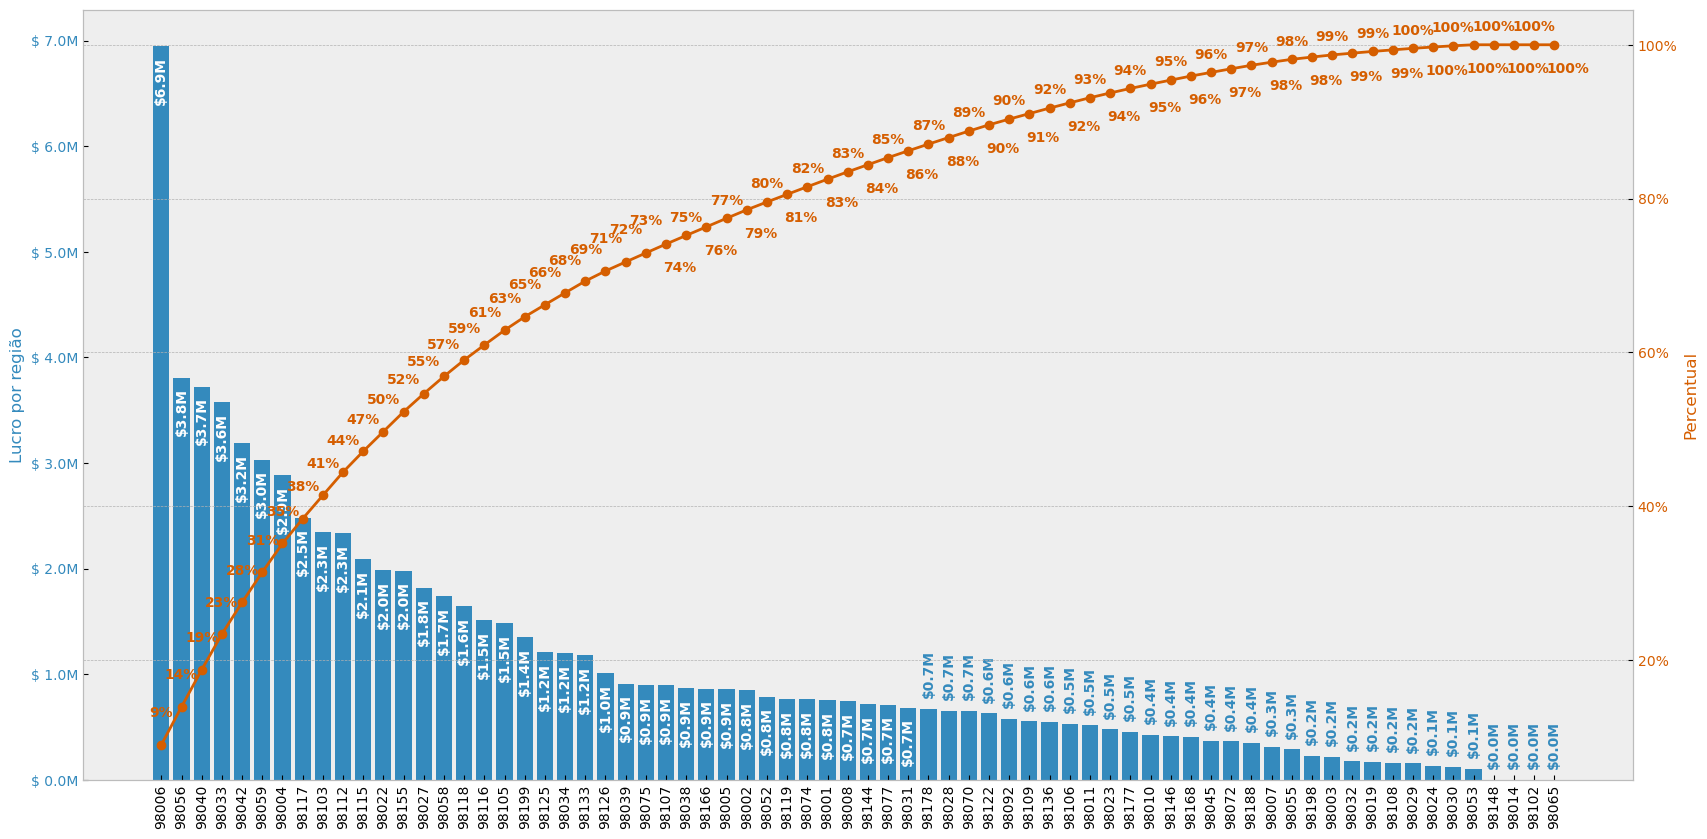

In [161]:
fig_pareto = teste_pareto()
fig_pareto.show()

C:\Users\rodri\AppData\Local\Temp\ipykernel_9904\2844864764.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_pareto.show()


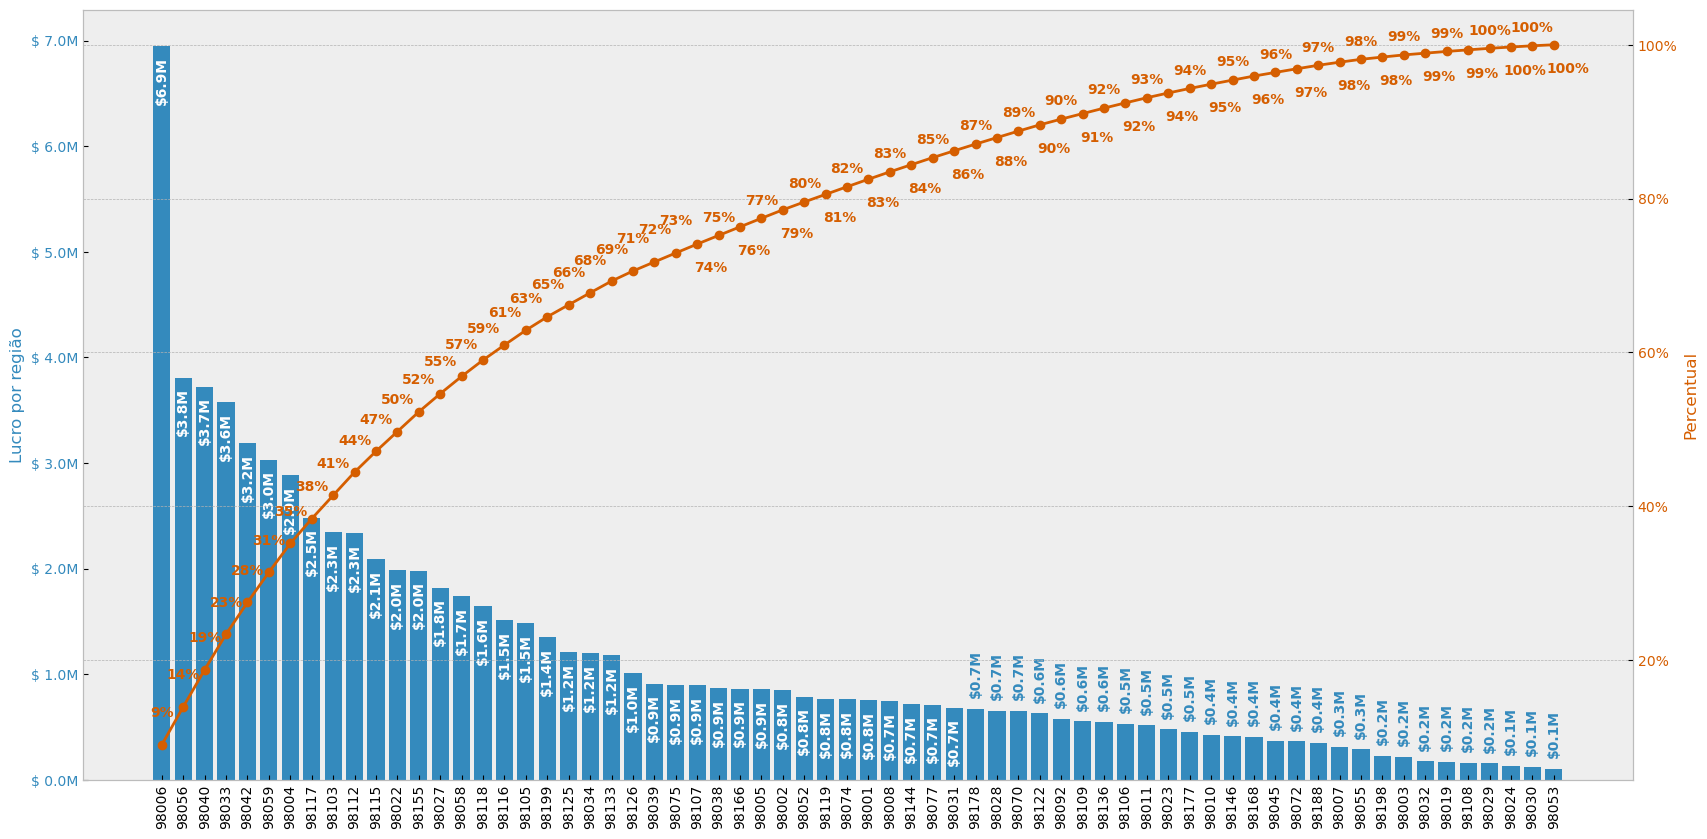

In [165]:
fig_pareto = teste_pareto()
fig_pareto.show()

#### 3.2. Filtros

In [ ]:
f_filters = widgets.Checkbox(
    value=True,
    description='Select all',
    disabled=False,
    indent=True
)

f_zipcode = widgets.Dropdown(
    options = data['zipcode'].sort_values().unique().tolist(),
    description = 'Region',
    disable = False
)

#### 3.3. Imóveis para compra/revenda

In [ ]:
mapdata = data[['id','lat','long','zipcode','buy','season','price','sell_price','profit']].copy()
mapdata.columns=[i.capitalize().replace('_',' ') for i in mapdata.columns]
mapdata['Season'] = mapdata['Season'].apply(lambda x: x.capitalize())
mapdata['Price'] = mapdata['Price'].apply(lambda x: f"${x*1e-3:1.1f}K")
mapdata['Sell price'] = mapdata['Sell price'].apply(lambda x: f"${x*1e-3:1.1f}K" if x != 0 else f"${x}")
mapdata['size'] = mapdata['Profit'].apply(lambda x: int(data.loc[data['profit']!=0,'profit'].min()*.7) if x == 0 else int(x))
mapdata['Profit'] = mapdata['Profit'].apply(lambda x: f"${x*1e-3:1.1f}K" if x != 0 else f"${x}")

In [ ]:
def make_map( mapdata = pd.DataFrame, filter_region = list, filter_clear = bool ) -> None: 
    """
    """
    
    #if mapdata == None:


    if filter_clear:
        mapdata
    else:
        mapdata = mapdata.loc[mapdata['Zipcode']==filter_region]
    
    _map = px.scatter_mapbox( mapdata,
                              lat='Lat',
                              lon='Long',                            
                              color='Buy',
                              color_discrete_sequence=['#999999','#0F3D6E'],
                              zoom=10,
                              size='size',
                              hover_data={'Id': True,
                                          'Lat': False,
                                          'Long': False,
                                          'Zipcode': True,
                                          'Buy': False,
                                          'Season': True,
                                          'Price': True,
                                          'Sell price': True,
                                          'Profit': True}
                            )
    _map.update_layout(mapbox_style='carto-positron')
    _map.update_layout(height=600, margin = {'r':0,'t':0,'l':0,'b':0})
    _map.show()
    
    return None

In [ ]:
interact( make_map, mapdata=fixed(mapdata), filter_region=f_zipcode, filter_clear=f_filters );

#### 3.4. Imóveis por estado de conservação

C:\Users\rodri\AppData\Local\Temp\ipykernel_9904\3091410256.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


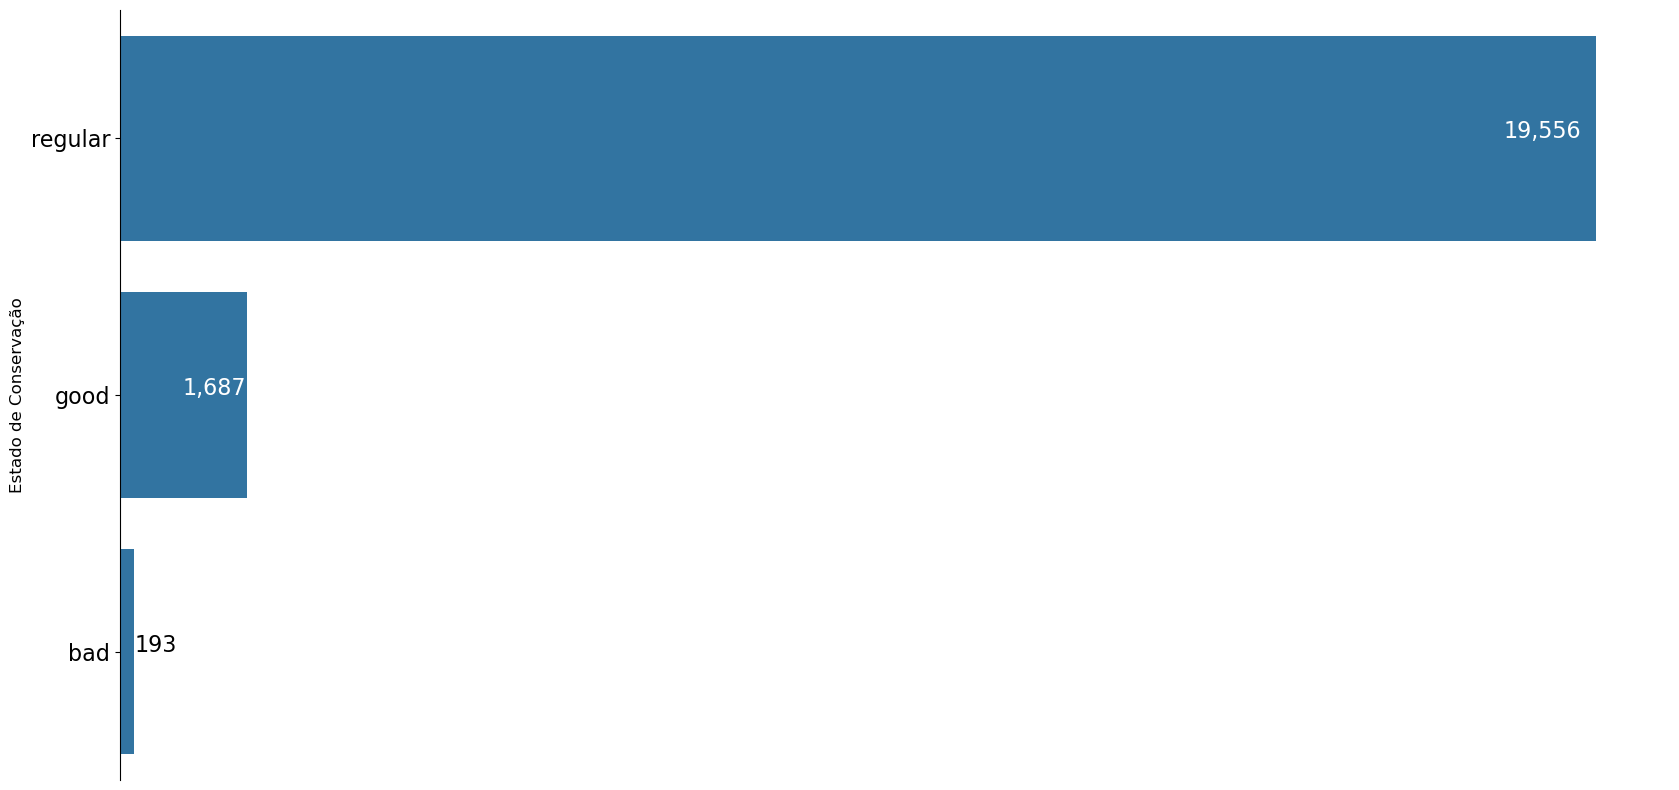

In [150]:
p = data[['condition_type','id']].groupby('condition_type').count().sort_values('id', ascending=False).reset_index(drop=False)

fig = plt.figure() 
#plt.plot(data=p)
ax = sns.barplot(p, x='id', y='condition_type')
ax.spines[['top','right','bottom']].set_visible(False)
for i, val in enumerate(p['id']):
    if i !=2:
        ax.annotate(f"{val:,d}",(val,i),ha="right",fontsize=16,xytext=(val-(val*.01), i),color="white")
    else:
        ax.annotate(f"{val:,d}",(val,i),ha="left",fontsize=16, xytext=(val+(val*.01), i))
plt.ylabel('Estado de Conservação',fontsize=12)
plt.xlabel('')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
#plt.bar_label(ax.containers[0], fontsize=16)
plt.yticks(fontsize=16)
fig.show();

#### 3.5. Rentabilidade por estação do ano

C:\Users\rodri\AppData\Local\Temp\ipykernel_9904\2007309819.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


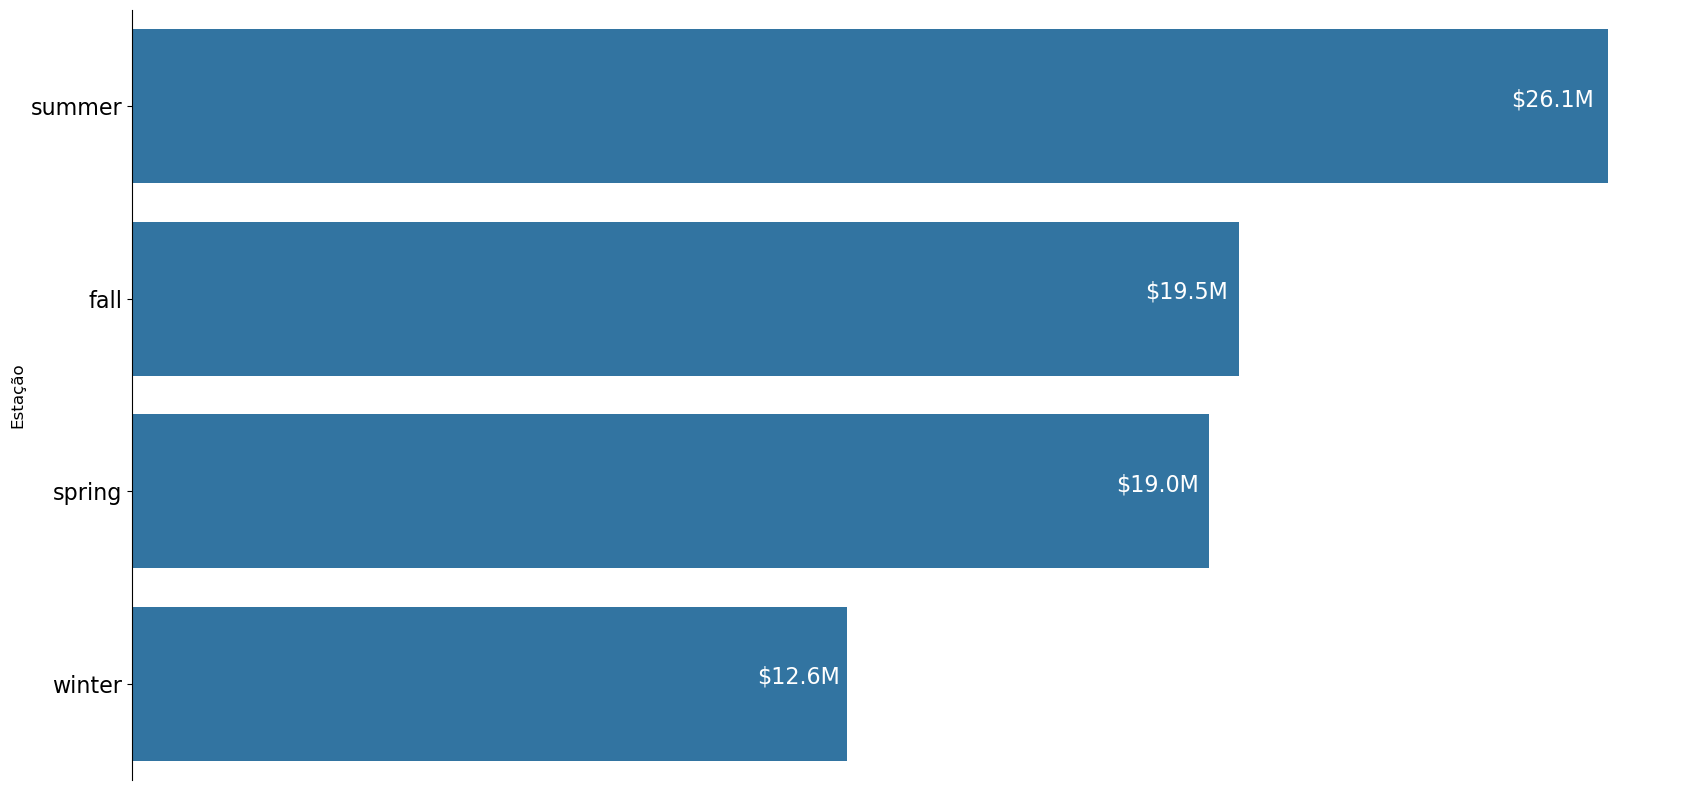

In [151]:
q = data.loc[data['buy']=="Yes",['season','profit']].groupby('season').sum().sort_values('profit',ascending=False).reset_index()
fig = plt.figure() 
ax = sns.barplot(q, x='profit', y='season')
ax.spines[['top','right','bottom']].set_visible(False)
for i, val in enumerate(q['profit']):
    ax.annotate(f"${val*1e-6:1.1f}M",(val,i),ha="right",fontsize=16,xytext=(val-(val*.01), i),color="white")
plt.ylabel('Estação',fontsize=12)
plt.xlabel('')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
#plt.bar_label(ax.containers[0], fontsize=16)
plt.yticks(fontsize=16)
fig.show();